In [1]:
import torch
import numpy as np
import pandas as pd
from torch import nn, optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
df=pd.read_csv("dataset.csv")
del df["id"]
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
43395,Female,10.0,0,0,No,children,Urban,58.64,20.4,never smoked,0
43396,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,55.4,formerly smoked,0
43397,Female,82.0,1,0,Yes,Private,Urban,91.94,28.9,formerly smoked,0
43398,Male,40.0,0,0,Yes,Private,Urban,99.16,33.2,never smoked,0


In [3]:
df.isnull().sum()

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [4]:
#결측값 있는 열 제거

del df["bmi"]
del df["smoking_status"]

In [5]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,0
2,Female,8.0,0,0,No,Private,Urban,110.89,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,0
...,...,...,...,...,...,...,...,...,...
43395,Female,10.0,0,0,No,children,Urban,58.64,0
43396,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,0
43397,Female,82.0,1,0,Yes,Private,Urban,91.94,0
43398,Male,40.0,0,0,Yes,Private,Urban,99.16,0


In [6]:
y=df[["stroke"]]
x=df.drop("stroke", axis=1)

In [7]:
y=y.values

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_attributes =["age","avg_glucose_level"]
x_num = x[num_attributes]

num_pipeline = Pipeline([
 
 ('std_scaler', StandardScaler()),
 ])
scaled_x_num = num_pipeline.fit_transform(x_num)

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


num_attribs =["age","avg_glucose_level"]
cat_attribs = ["gender","hypertension","heart_disease","ever_married","work_type","Residence_type"]
full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OneHotEncoder(), cat_attribs),
 ])
x_prepared = full_pipeline.fit_transform(x)

In [10]:
x_prepared.shape

(43400, 18)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(x_prepared, y, test_size=0.33, random_state=42)

X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [12]:
 model = nn.Sequential(
          nn.Linear(18, 50, bias=True), # input_layer = 2, hidden_layer1 = 10 
          nn.Sigmoid(),
          nn.Linear(50, 100, bias=True), # hidden_layer1 = 10, hidden_layer2 = 10
          nn.Sigmoid(),
          nn.Linear(100, 1, bias=True), # hidden_layer3 = 10, output_layer = 1
          nn.Sigmoid()
          ).to(device)

In [13]:
loss_fn = nn.BCELoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=1)

In [14]:
losses = []
for epoch in range(100):

    optimizer.zero_grad()
    # forward 연산
    hypothesis = model(X_train)

    # 비용 함수
    cost = loss_fn(hypothesis, y_train)
    cost.backward()
    optimizer.step()
    losses.append(cost.item()) # 값만 가져오기 위해서 .item()

    # 10의 배수에 해당되는 에포크마다 비용을 출력
    if epoch % 10 == 0:
        print(epoch, cost.item())

0 0.7644796371459961
10 0.1669142097234726
20 0.09728600084781647
30 0.08902323991060257
40 0.08898232132196426
50 0.08894357830286026
60 0.08890467882156372
70 0.08886554837226868
80 0.08882612735033035
90 0.08878634870052338


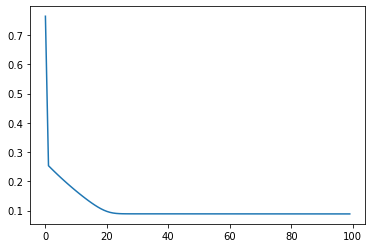

In [15]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [16]:
with torch.no_grad():

    model = model.to('cpu')
    y_pred = model(X_test)

    y_pred = y_pred.detach().numpy() # tensor를 numpy로 바꿈
    predicted = np.argmax(y_pred,axis=1)
    print(f'model의 output은 :  {y_pred[0]}' )
    print(f'sigmoid를 한 후의 output은 {predicted[0]}')
    accuracy = (accuracy_score(predicted,y_test))
    print(f'accuracy는 {accuracy}')

model의 output은 :  [0.01790208]
sigmoid를 한 후의 output은 0
accuracy는 0.9813573523250942
